<a href="https://colab.research.google.com/github/Varshini2005/Winter-Project-2024/blob/main/Index_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving nifty_for_index_tracking.xlsx to nifty_for_index_tracking.xlsx


# New Section

In [2]:
import pandas as pd
# Load the uploaded Excel file into a DataFrame
df = pd.read_excel("nifty_for_index_tracking.xlsx")

# Display the first few rows of the DataFrame
print(df.head())



       Dates  EIM IS Equity  AXSB IS Equity  BJFIN IS Equity  \
0 2020-01-01        2207.58          748.70           937.85   
1 2020-01-02        2160.09          756.95           950.56   
2 2020-01-03        2118.93          742.95           934.59   
3 2020-01-06        2086.05          723.25           904.27   
4 2020-01-07        2080.38          725.75           909.57   

   SBILIFE IS Equity  RELIANCE IS Equity  ITC IS Equity  MM IS Equity  \
0             976.40             1362.37         238.10        536.60   
1             969.35             1385.56         239.85        539.85   
2             975.10             1387.23         238.50        532.75   
3             983.10             1355.06         235.10        524.50   
4             984.90             1375.91         235.35        526.65   

   SBIN IS Equity  HNDL IS Equity  ...  HDFCLIFE IS Equity  DIVI IS Equity  \
0          334.45          214.30  ...              621.45         1818.85   
1          339.30   

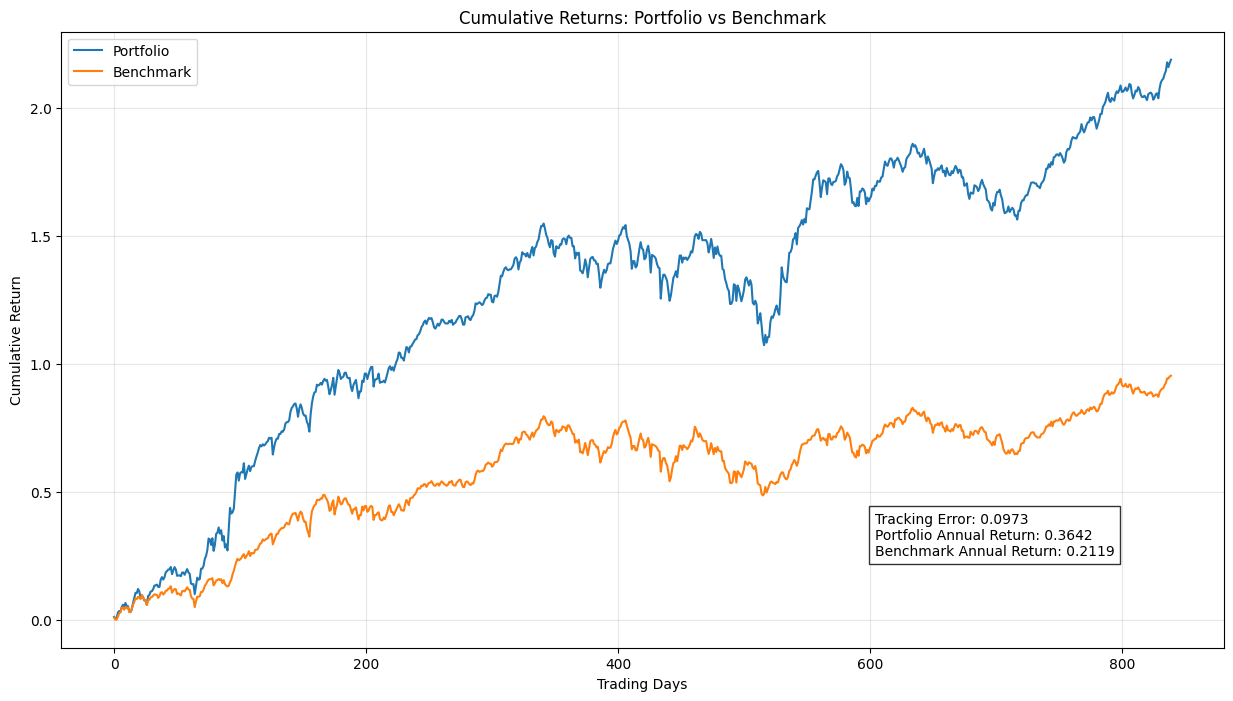

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def train_index_tracking_model(stock_returns, index_returns, alpha=0.01):
    """Train index tracking model with weight validation."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(stock_returns)
    # apply lasso regression.
    lasso = Lasso(alpha=alpha, positive=True, fit_intercept=False)
    lasso.fit(X_train_scaled, index_returns)

    weights = lasso.coef_
    # Handle zero-sum weights
    if np.sum(weights) <= 1e-10:
        weights = np.ones(len(weights)) / len(weights)
    else:
        weights = weights / np.sum(weights)

    return weights

def rolling_window_analysis(df, training_days=126, testing_days=21, alpha=0.01):
    """Perform rolling window analysis with proper return calculation."""
    # Seperate the stock columns
    stock_columns = [col for col in df.columns if col not in ['Dates', 'NIFTY Index']]
    # calcuate daily retuns for each of stocks and the index
    returns_df = df[stock_columns + ['NIFTY Index']].pct_change().dropna()

    # Initialize results storage
    portfolio_returns_list = []
    benchmark_returns_list = []
    dates_list = []
    # Calculate the total length of our data
    total_rows = len(returns_df)
    # calculate how many times we have to run our analysis
    num_windows = (total_rows - training_days) // testing_days

    for i in range(num_windows):
        # calculate the testing and training dates for each of the window
        train_start = i * testing_days
        train_end = train_start + training_days
        test_start = train_end
        test_end = min(test_start + testing_days, total_rows)

        # Skip if not enough data remains
        if test_end - test_start < 5:
            break

        train_stocks = returns_df[stock_columns].iloc[train_start:train_end]
        train_index = returns_df['NIFTY Index'].iloc[train_start:train_end]
        # pass the whole window of stocks and index returns to perform lasso
        # regression
        weights = train_index_tracking_model(train_stocks, train_index, alpha)
        # frame the testing window
        test_stocks = returns_df[stock_columns].iloc[test_start:test_end]
        test_index = returns_df['NIFTY Index'].iloc[test_start:test_end]
        # calculate daily portfolio returns
        portfolio_returns = np.sum(test_stocks * weights, axis=1)
        # append the daily stock return to the final list
        portfolio_returns_list.extend(portfolio_returns)
        benchmark_returns_list.extend(test_index)
        dates_list.extend(df.index[test_start:test_end])
    # return the final portfolio returns, benchmark returns and dates list.
    return np.array(portfolio_returns_list), np.array(benchmark_returns_list), dates_list

def plot_cumulative_returns(portfolio_returns, benchmark_returns):
    """Plot cumulative returns with improved visualization."""
    # calculate portfolio cumulative returns
    port_cumulative = np.cumprod(1 + portfolio_returns) - 1
    # calculate benchmark cumulative returns
    bench_cumulative = np.cumprod(1 + benchmark_returns) - 1
    # plot the graph
    plt.figure(figsize=(15, 8))
    plt.plot(port_cumulative, label='Portfolio', linewidth=1.5)
    plt.plot(bench_cumulative, label='Benchmark', linewidth=1.5)
    plt.title('Cumulative Returns: Portfolio vs Benchmark')
    plt.xlabel('Trading Days')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Calculate and display metrics
    # Annual standard deviation in tracking error
    tracking_error = np.std(portfolio_returns - benchmark_returns) * np.sqrt(252)
    # Annual portfolio and benchmark return
    annual_port_return = np.mean(portfolio_returns) * 252
    annual_bench_return = np.mean(benchmark_returns) * 252

    plt.text(0.7, 0.15, f'Tracking Error: {tracking_error:.4f}\n' +
             f'Portfolio Annual Return: {annual_port_return:.4f}\n' +
             f'Benchmark Annual Return: {annual_bench_return:.4f}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

# Run our main command
portfolio_returns, benchmark_returns, dates = rolling_window_analysis(df) # We will get back here a list of portfolio returns, benchmakr returns with dates.
plot_cumulative_returns(portfolio_returns, benchmark_returns) # This function will be used for plotting the returns.

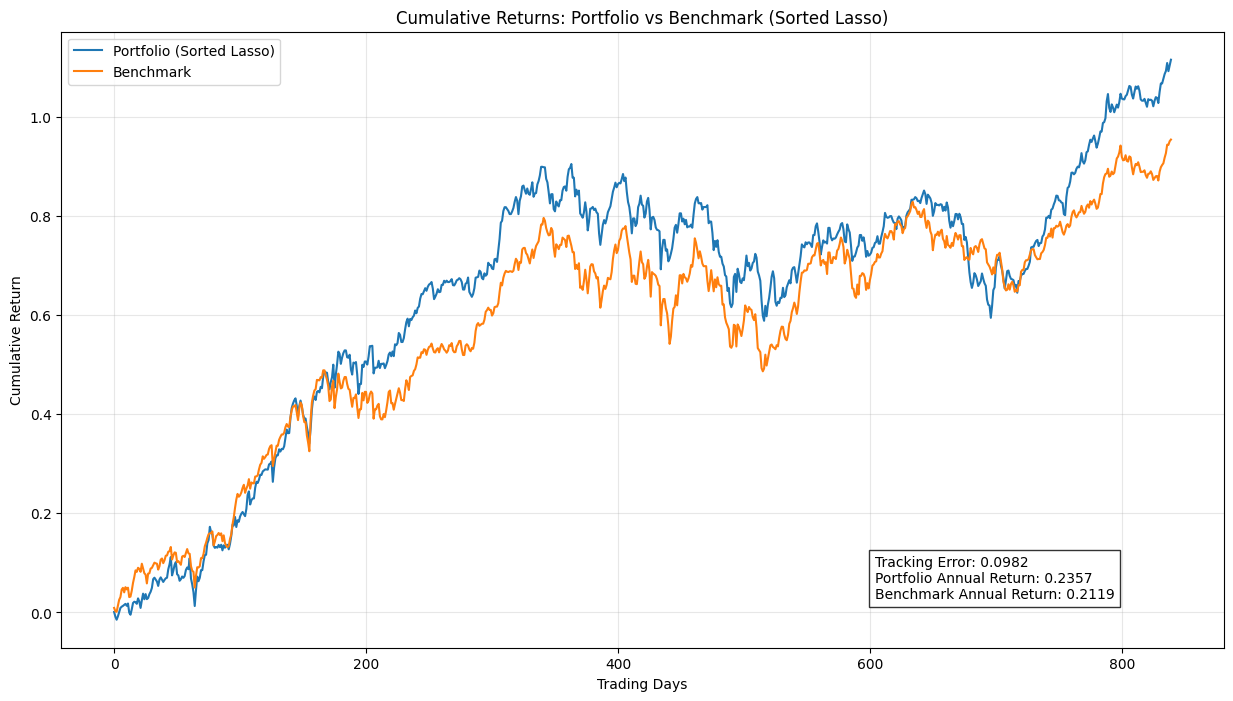

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def sorted_lasso(X, y, alpha):
    """Perform Sorted L1 regression to optimize weights.
    Args:
        X (numpy.ndarray): Feature matrix (stock returns).
        y (numpy.ndarray): Target vector (index returns).
        alpha (float): Regularization parameter.

    Returns:
        numpy.ndarray: Optimized weights for the portfolio.
    """
    n_features = X.shape[1]

    # Define the objective function for sorted L1 regularization
    def objective(w):
        residuals = y - X @ w  # Compute residuals
        sorted_weights = np.sort(np.abs(w))[::-1]  # Sort weights by absolute value in descending order
        penalty = alpha * np.sum(sorted_weights * np.arange(1, n_features + 1))  # Apply sorted L1 penalty
        return np.sum(residuals**2) / 2 + penalty

    # Constraints for the optimization: non-negative weights and sum to 1
    constraints = (
        {'type': 'ineq', 'fun': lambda w: w},  # Non-negative weights
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights sum to 1
    )

    # Initial guess for weights (uniform distribution)
    initial_weights = np.ones(n_features) / n_features

    # Minimize the objective function subject to constraints
    result = minimize(objective, initial_weights, constraints=constraints, method='SLSQP')

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed")

def train_sorted_lasso_model(stock_returns, index_returns, alpha=0.01):
    """Train index tracking model using Sorted L1 regression.
    Args:
        stock_returns (pd.DataFrame): Training stock returns.
        index_returns (pd.Series): Training index returns.
        alpha (float): Regularization parameter.

    Returns:
        numpy.ndarray: Optimized weights for the portfolio.
    """
    scaler = StandardScaler()  # Initialize scaler
    X_train_scaled = scaler.fit_transform(stock_returns)  # Standardize the training data

    weights = sorted_lasso(X_train_scaled, index_returns, alpha)  # Train the model
    return weights

def rolling_window_analysis_sorted_lasso(df, training_days=126, testing_days=21, alpha=0.01):
    """Perform rolling window analysis using Sorted Lasso.
    Args:
        df (pd.DataFrame): DataFrame containing stock and index data.
        training_days (int): Number of training days in each window.
        testing_days (int): Number of testing days in each window.
        alpha (float): Regularization parameter.

    Returns:
        tuple: Portfolio returns, benchmark returns, and corresponding dates.
    """
    # Identify stock columns excluding date and index columns
    stock_columns = [col for col in df.columns if col not in ['Dates', 'NIFTY Index']]

    # Calculate percentage returns and drop NaN values
    returns_df = df[stock_columns + ['NIFTY Index']].pct_change().dropna()

    portfolio_returns_list = []  # To store portfolio returns
    benchmark_returns_list = []  # To store benchmark (index) returns
    dates_list = []  # To store corresponding dates

    total_rows = len(returns_df)
    num_windows = (total_rows - training_days) // testing_days  # Calculate number of rolling windows

    for i in range(num_windows):
        # Define training and testing periods
        train_start = i * testing_days
        train_end = train_start + training_days
        test_start = train_end
        test_end = min(test_start + testing_days, total_rows)

        if test_end - test_start < 5:
            break  # Skip if test period is too short

        # Split training and testing data
        train_stocks = returns_df[stock_columns].iloc[train_start:train_end]
        train_index = returns_df['NIFTY Index'].iloc[train_start:train_end]

        # Train the model and get weights
        weights = train_sorted_lasso_model(train_stocks, train_index, alpha)

        test_stocks = returns_df[stock_columns].iloc[test_start:test_end]
        test_index = returns_df['NIFTY Index'].iloc[test_start:test_end]

        # Calculate portfolio returns for the test period
        portfolio_returns = np.sum(test_stocks.values * weights, axis=1)
        portfolio_returns_list.extend(portfolio_returns)
        benchmark_returns_list.extend(test_index.values)
        dates_list.extend(df.index[test_start:test_end])

    return np.array(portfolio_returns_list), np.array(benchmark_returns_list), dates_list

def plot_cumulative_returns_sorted_lasso(portfolio_returns, benchmark_returns):
    """Plot cumulative returns for Sorted Lasso.
    Args:
        portfolio_returns (numpy.ndarray): Portfolio returns.
        benchmark_returns (numpy.ndarray): Benchmark (index) returns.
    """
    # Calculate cumulative returns
    port_cumulative = np.cumprod(1 + portfolio_returns) - 1
    bench_cumulative = np.cumprod(1 + benchmark_returns) - 1

    plt.figure(figsize=(15, 8))
    plt.plot(port_cumulative, label='Portfolio (Sorted Lasso)', linewidth=1.5)
    plt.plot(bench_cumulative, label='Benchmark', linewidth=1.5)
    plt.title('Cumulative Returns: Portfolio vs Benchmark (Sorted Lasso)')
    plt.xlabel('Trading Days')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Calculate and display key metrics
    tracking_error = np.std(portfolio_returns - benchmark_returns) * np.sqrt(252)
    annual_port_return = np.mean(portfolio_returns) * 252
    annual_bench_return = np.mean(benchmark_returns) * 252

    # Adjust position of text annotations to avoid overlap
    plt.text(0.7, 0.15,  # Adjusted location
             f'Tracking Error: {tracking_error:.4f}\n'
             f'Portfolio Annual Return: {annual_port_return:.4f}\n'
             f'Benchmark Annual Return: {annual_bench_return:.4f}',
             transform=plt.gca().transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

portfolio_returns, benchmark_returns, dates = rolling_window_analysis_sorted_lasso(df)
plot_cumulative_returns_sorted_lasso(portfolio_returns, benchmark_returns)
